In [1]:
import sys 
import os
import pandas as pd
import numpy as np
from pathlib import Path 
from PIL import Image
import time
import datetime
from sklearn.model_selection import train_test_split


print(pd.__version__)
print(np.__version__)
!python -V
!pwd

dir_meta = Path('meta')
dir_meta.mkdir(exist_ok=True, parents=True)

1.3.4
1.20.3
Python 3.9.7
/home/esslab/AI_projects/shared/eBird/download_ebird


### 建立ebird_finetune(train / validation)
##### 資料目錄結構
```
--- ebird_finetune
     |___ train/
     |___ val/
     |___ test/
```

### 建立物種清單
#### 物種篩選
- 分類單元以`Parent Species`欄位為依據
    - 物種(屬名 種名)
- 物種選擇依據`Taxon Category`欄位
    - selected: 'Species', 'Group', 'Intergrade', 'Form'
    - excluded: 'Spuh', 'Slash', 'Hybrid', 'Domestic'

- 確認可用的物種數

### 切分資料
#### Stratified Random Sampling 分層隨機抽樣
- 每個物種單元按 6:2:2 切分給train, validation, test 
- if n<10: 
    - ~~直接分配給train~~
    - 捨棄

#### 目錄以物種為單位將檔案放入
- 物種目錄命名規則
    - label_(Order)_Family_Genus_Sp
- Label排序
    - 按"科- 學名" 
    - Train Set :Label會廊括所有的物種


##### 建立 meta data
- 另外產出一份針對Testing Dataset的meta data
- 根據此份meta data產出Testing Dataset所需資料
- 類群欄位(order, family)根据ebird網站公布名錄資料填入
    - [Downloadable Checklist](https://www.birds.cornell.edu/clementschecklist/download/?__hstc=60209138.465289e4a37080eba45c20a8cef0b9e3.1652929699202.1653028085131.1653030950878.5&__hssc=60209138.1.1653030950878&__hsfp=1302880087)

#### reference
- [The eBird Taxonomy](https://ebird.org/science/use-ebird-data/the-ebird-taxonomy)

## Load Meta data
- meta file : 'jpg_top100_meta3.csv'

In [10]:
%%time
meta_file = dir_meta/'jpg_top100_meta3.csv'
df_jpg100_meta = pd.read_csv(meta_file, index_col=0, 
                            #  dtype=column_dtypes
                             )
df_jpg100_meta.info()

/home/esslab/anaconda3/lib/python3.9/site-packages/IPython/core/magics/execution.py:1324: DtypeWarning: Columns (31,32,33,60) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 896555 entries, 0 to 896554
Data columns (total 62 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ML Catalog Number            896555 non-null  int64  
 1   Dir_FName                    896555 non-null  object 
 2   Parent_Dir                   896555 non-null  object 
 3   Size                         896555 non-null  float64
 4   Sci_N                        896555 non-null  object 
 5   Macaulay_public              37 non-null      float64
 6   Format                       896521 non-null  object 
 7   Scientific Name              896535 non-null  object 
 8   Common Name                  896521 non-null  object 
 9   Background Species           1807 non-null    object 
 10  Recordist                    896478 non-null  object 
 11  Date                         884239 non-null  object 
 12  Year                         884239 non-null  float64
 13 

In [54]:
col_basic =  ['ML Catalog Number','Dir_FName', 'Parent_Dir', 'Sci_N', 'Macaulay_public']
# col_geo = ['County', 'Locality', 'Latitude','Longitude']
col_taxon = ['Family', 'Scientific Name',  'Parent Species', 'Taxon Category']
col_state = ['Age/Sex', 'Behaviors']
col_rating = ['Number of Ratings', 'Average Community Rating',]

## 建立物種清單

### 物種篩選
- 分類單元以`Parent Species`欄位為依據
    - 物種(屬名 種名)
- 物種選擇依據`Taxon Category`欄位
    - selected: 'Species', 'Group', 'Intergrade', 'Form'
    - excluded: 'Spuh', 'Slash', 'Hybrid', 'Domestic'

- 確認可用的物種數

In [55]:
mask =  df_jpg100_meta['Taxon Category'].isin(['Species', 'Group', 'Intergrade', 'Form'])
df_sp_sel = df_jpg100_meta[col_basic + col_taxon + col_rating + col_state][mask]
df_sp_sel

,ML Catalog Number,Dir_FName,Parent_Dir,Sci_N,Macaulay_public,Family,Scientific Name,Parent Species,Taxon Category,Number of Ratings,Average Community Rating,Age/Sex,Behaviors
0,114289801,Acanthisittidae/Acanthisitta_chloris_0_114289801,Acanthisittidae,Acanthisitta_chloris_0,NaN,Acanthisittidae,Acanthisitta chloris,Acanthisitta chloris,Species,2.0,4.000,Unknown,NaN
1,114289821,Acanthisittidae/Acanthisitta_chloris_0_114289821,Acanthisittidae,Acanthisitta_chloris_0,NaN,Fringillidae,Acanthisitta chloris,Acanthisitta chloris,Species,2.0,4.000,Unknown,NaN
2,114404941,Acanthisittidae/Acanthisitta_chloris_0_114404941,Acanthisittidae,Acanthisitta_chloris_0,NaN,Acanthisittidae,Acanthisitta chloris,Acanthisitta chloris,Species,2.0,4.500,Unknown,NaN
3,114404951,Acanthisittidae/Acanthisitta_chloris_0_114404951,Acanthisittidae,Acanthisitta_chloris_0,NaN,Fringillidae,Acanthisitta chloris,Acanthisitta chloris,Species,2.0,4.000,Unknown,NaN
4,115495451,Acanthisittidae/Acanthisitta_chloris_0_115495451,Acanthisittidae,Acanthisitta_chloris_0,NaN,Acanthisittidae,Acanthisitta chloris,Acanthisitta chloris,Species,21.0,4.906,Unknown,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
896550,59630711,Zosteropidae/Zosterornis_whiteheadi_0_59630711,Zosteropidae,Zosterornis_whiteheadi_0,NaN,Zosteropidae,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,1.0,3.000,Unknown,NaN
896551,59630721,Zosteropidae/Zosterornis_whiteheadi_0_59630721,Zosteropidae,Zosterornis_whiteheadi_0,NaN,Zosteropidae,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,0.0,0.000,Unknown,NaN
896552,63554951,Zosteropidae/Zosterornis_whiteheadi_0_63554951,Zosteropidae,Zosterornis_whiteheadi_0,NaN,Zosteropidae,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,1.0,3.000,Unknown,NaN
896553,79738531,Zosteropidae/Zosterornis_whiteheadi_0_79738531,Zosteropidae,Zosterornis_whiteheadi_0,NaN,Zosteropidae,Zosterornis whiteheadi,Zosterornis whiteheadi,Species,4.0,3.000,Unknown,NaN


In [76]:
# 檢視 'Parent Species'缺值資料
# df_sp_sel.dropna(subset=['Parent Species'])
df_sp_sel[df_sp_sel['Parent Species'] == 'Brachypteryx montana']  # n=68
df_sp_sel[df_sp_sel['Parent Species'].isnull()]                   # n=13       

# 挑選兩張其實很難做物種辨識或根本不是鳥的照片
# https://macaulaylibrary.org/asset/166321911 僅鳥巢
# https://macaulaylibrary.org/asset/166321941 鳥巢與一點鳥影


,ML Catalog Number,Dir_FName,Parent_Dir,Sci_N,Macaulay_public,Family,Scientific Name,Parent Species,Taxon Category,Number of Ratings,Average Community Rating,Age/Sex,Behaviors
414647,111151791,Muscicapidae/Brachypteryx_montana_0_111151791,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,2.0,3.0,Juvenile Female,NaN
414648,111152311,Muscicapidae/Brachypteryx_montana_0_111152311,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,2.0,3.0,Unknown,NaN
414649,111180031,Muscicapidae/Brachypteryx_montana_0_111180031,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,3.0,3.0,Adult Female,NaN
414651,139669831,Muscicapidae/Brachypteryx_montana_0_139669831,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,1.0,3.0,Adult Male,NaN
414652,139669841,Muscicapidae/Brachypteryx_montana_0_139669841,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,2.0,3.0,Adult Female,Nest
414653,139669861,Muscicapidae/Brachypteryx_montana_0_139669861,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,1.0,3.0,Adult Male,NaN
414654,139669981,Muscicapidae/Brachypteryx_montana_0_139669981,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,2.0,3.0,Adult Female,NaN
414655,139669991,Muscicapidae/Brachypteryx_montana_0_139669991,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,3.0,3.0,Adult Female,NaN
414656,139670001,Muscicapidae/Brachypteryx_montana_0_139670001,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,2.0,3.0,Adult Female,NaN
414657,139670091,Muscicapidae/Brachypteryx_montana_0_139670091,Muscicapidae,Brachypteryx_montana_0,NaN,Muscicapidae,Brachypteryx montana erythrogyna,NaN,Group,1.0,3.0,Adult Male,NaN


In [599]:
sp_list = df_sp_sel['Parent Species'].dropna().unique()
print(f"Number of recognizable Species : {len(sp_list):,d}")
sp_list


Number of recognizable Species : 10,338


array(['Acanthisitta chloris', 'Xenicus gilviventris',
       'Acanthiza apicalis', ..., 'Zosterornis nigrorum',
       'Zosterornis striatus', 'Zosterornis whiteheadi'], dtype=object)

### 建立物種清單、對應編號、各物種樣本數

In [600]:
sp_count = (df_sp_sel.dropna(subset=['Parent Species'])
            .groupby(['Parent Species'])['ML Catalog Number'].count()
            .reset_index().reset_index()
            .set_axis(['Label','Specie','Count'],  axis=1)
           )
sp_count

,Label,Specie,Count
0,0,Abeillia abeillei,100
1,1,Abroscopus albogularis,100
2,2,Abroscopus schisticeps,100
3,3,Abroscopus superciliaris,100
4,4,Aburria aburri,79
...,...,...,...
10333,10333,Zosterornis hypogrammicus,10
10334,10334,Zosterornis latistriatus,3
10335,10335,Zosterornis nigrorum,4
10336,10336,Zosterornis striatus,8


,Count
count,10338.000000
mean,83.559296
std,66.224603
min,1.000000
25%,38.000000
50%,99.000000
75%,100.000000
max,1121.000000


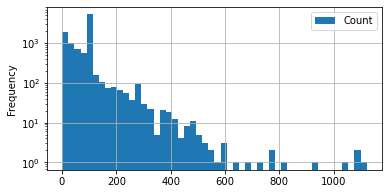

In [123]:
sp_count[['Specie','Count']].plot.hist(bins=50, logy=True, grid=True, figsize=(6,3)) ;
# print(sp_count.query('Count>=50').__len__())
sp_count[['Specie','Count']].describe()

## 切分資料
- get `ML Catalog Number` by specie 
- split 'ML Catalog Number' by ratio
    - if n<10, assign to 'train' directly

pseudo code :
```
# key = 'ML Catalog Number'
train_list, val_list, test_list = [], [], []
dataset_list = train_list, val_list, test_list

def random_assign(data_list:List, split_ration):
    return data_list #  by split_ratio

def split_dataset(mlsns_sp, split_ration=(6,2,2)):
    if n>=10:
        mlsns_sp_dataset = random_assign(mlsns_sp, split_ration) # return mlsns of train, val, test  
            list_.append(mlsns_sp_)
    else: 
        train_list.append(mlsns_sp)
        
        
for sp, mlsns_sp in dataframe : 
    split_dataset
    
    
```


### Stratified Random Sampling 分層隨機抽樣
- 每個物種單元按比例 切分給train, validation, test 
- 如果n<10
    - ~~直接分配給train~~
    - 捨棄

In [581]:
train_list, val_list, test_list = [], [], []
dataset_list = [train_list, val_list, test_list]

def data_split(data_list:list, split_ratio:list=[0.6, 0.2, 0.2]):
    assert  len(split_ratio) == 3
    
    train_ratio = split_ratio[0]/sum(split_ratio)
    train_, test_ = train_test_split(data_list, train_size= train_ratio, random_state=seed)
    
    test_ratio = split_ratio[2]/sum(split_ratio[1:]) 
    val_, test_ = train_test_split(test_, test_size=test_ratio, random_state=seed)
    return train_, val_, test_ #  by split_ratio

def assign_dataset(mlsns_sp:list, split_ratio:list=[6,2,2], n_threshold:int=10):
    if len(mlsns_sp) >= n_threshold:
        mlsns_sp_dataset = data_split(mlsns_sp, split_ratio=split_ratio) # return mlsns of train, val, test 
        for list_, mlsns_sp_ in zip(dataset_list, mlsns_sp_dataset):
            list_ += list(mlsns_sp_)
    else: 
        # dataset_list[0] += list(mlsns_sp)
        pass
    

In [583]:
sp_count

,Label,Specie,Count,Dir_class
0,0,Abeillia abeillei,100,0_Abeillia_abeillei
1,1,Abroscopus albogularis,100,1_Abroscopus_albogularis
2,2,Abroscopus schisticeps,100,2_Abroscopus_schisticeps
3,3,Abroscopus superciliaris,100,3_Abroscopus_superciliaris
4,4,Aburria aburri,79,4_Aburria_aburri
...,...,...,...,...
10333,10333,Zosterornis hypogrammicus,10,10333_Zosterornis_hypogrammicus
10334,10334,Zosterornis latistriatus,3,10334_Zosterornis_latistriatus
10335,10335,Zosterornis nigrorum,4,10335_Zosterornis_nigrorum
10336,10336,Zosterornis striatus,8,10336_Zosterornis_striatus


In [584]:
# %%time
seed = 1 
split_ratio=[6, 2, 2] # train : val :test

train_list, val_list, test_list = [], [], []
dataset_list = [train_list, val_list, test_list]

start_time = time.time()
for idx, rows in sp_count.iterrows():
    label_, sp_, *_ = rows
    
    mlcns_sp_ = df_sp_sel[df_sp_sel['Parent Species'] == sp_]['ML Catalog Number'].values
    assign_dataset(mlcns_sp_, split_ratio=split_ratio)
    
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'Time : {passing_time} '
    info += f'| Progess : [{idx:5,d}/{len(sp_count)}] | {sp_:25s} '
    info += f'|　train:{len(train_list):5,d}. val:{len(val_list):5,d}. test:{len(test_list):5,d}. '
    # info += f'| {[len(list_) for list_ in dataset_list] }'
    print(info, end='\r')

    # if idx == 50 :
    #     break

In [597]:
to_df = lambda dataset_, list_: pd.DataFrame(list_, [dataset_]*len(list_)) .reset_index().set_axis(['Dataset', 'Mlcn'], axis=1)

dataset_df_list = [to_df( dataset_, data_list_) 
                   for dataset_, data_list_ in 
                   zip(['train', 'val', 'test'], dataset_list)]

df_test_dataset =  pd.concat(dataset_df_list, axis=0)
print(df_test_dataset[df_test_dataset.duplicated(subset=['Mlcn'], keep=False)].__len__()) # 確認無重複

df_test_dataset


0


,Dataset,Mlcn
0,train,71911791
1,train,21716841
2,train,47883481
3,train,119299841
4,train,66545181
...,...,...
173931,test,253629991
173932,test,191769881
173933,test,122139621
173934,test,219727781


In [4]:
# ! ls -ld downloaded/ebird_testing/*/* | wc -l
# ! ls -l downloaded/ebird_testing/*/* |grep  -c  jpg
! ls -ld downloaded/ebird_testing/train/* |wc -l
! ls -ld downloaded/ebird_testing/val/* | wc -l
! ls -ld downloaded/ebird_testing/test/* | wc -l
# df_test_dataset_path.groupby('Dataset').Specie.count()


9484
9484
9484


In [3]:
! ls -a downloaded/ebird_testing/*/* |grep ipynb |xargs rm -rv

removed '.ipynb_checkpoints/establish_Testing_Dataset-checkpoint.ipynb'
removed '.ipynb_checkpoints/prepare_val_ebird_as_iNat-checkpoint.ipynb'
removed directory '.ipynb_checkpoints'
rm: cannot remove '.ipynb_checkpoints': No such file or directory


In [596]:
path_testing = 'meta/ebird_dataset_testing.csv'
df_test_dataset.to_csv(path_testing)
df_test_dataset = pd.read_csv(path_testing, index_col=0)
df_test_dataset

,Dataset,Mlcn
0,train,71911791
1,train,21716841
2,train,47883481
3,train,119299841
4,train,66545181
...,...,...
173931,test,253629991
173932,test,191769881
173933,test,122139621
173934,test,219727781


In [598]:
df_test_dataset_path = (df_test_dataset.merge(df_sp_sel[['ML Catalog Number', 'Dir_FName','Family', 'Parent Species']], 
                          left_on='Mlcn', right_on='ML Catalog Number' 
                         ).drop(columns=['ML Catalog Number'])
                        .merge(sp_count, 
                          left_on='Parent Species', right_on='Specie')
                        .drop(columns=['Parent Species', 'Count'])
                       )
df_test_dataset_path

,Dataset,Mlcn,Dir_FName,Family,Label,Specie,Dir_class
0,train,71911791,Trochilidae/Abeillia_abeillei_0_71911791,Trochilidae,0,Abeillia abeillei,0_Abeillia_abeillei
1,train,21716841,Trochilidae/Abeillia_abeillei_0_21716841,Trochilidae,0,Abeillia abeillei,0_Abeillia_abeillei
2,train,47883481,Trochilidae/Abeillia_abeillei_0_47883481,Trochilidae,0,Abeillia abeillei,0_Abeillia_abeillei
3,train,119299841,Trochilidae/Abeillia_abeillei_0_119299841,Trochilidae,0,Abeillia abeillei,0_Abeillia_abeillei
4,train,66545181,Trochilidae/Abeillia_abeillei_0_66545181,Trochilidae,0,Abeillia abeillei,0_Abeillia_abeillei
...,...,...,...,...,...,...,...
859475,test,253629991,Zosteropidae/Zosterornis_whiteheadi_0_253629991,Zosteropidae,10337,Zosterornis whiteheadi,10337_Zosterornis_whiteheadi
859476,test,191769881,Zosteropidae/Zosterornis_whiteheadi_0_191769881,Zosteropidae,10337,Zosterornis whiteheadi,10337_Zosterornis_whiteheadi
859477,test,122139621,Zosteropidae/Zosterornis_whiteheadi_0_122139621,Zosteropidae,10337,Zosterornis whiteheadi,10337_Zosterornis_whiteheadi
859478,test,219727781,Zosteropidae/Zosterornis_whiteheadi_0_219727781,Zosteropidae,10337,Zosterornis whiteheadi,10337_Zosterornis_whiteheadi


### 目錄以物種為單位將檔案放入
- 根據label_sp 名建立目錄 
    - 物種目錄命名規則
        - label_(Order)_Family_Genus_Sp
- 根據隨機mlcn索引、查找檔案路徑
    - 固定隨機切分時的隨機種子，讓切分名單固定

- 將檔案根據物種名放入



#### 根據label_sp 名建立目錄

In [601]:
# !pwd
# !ls -l downloaded/
dir_ebird_testing = Path('downloaded/ebird_finetune')

for idx, (label_, sp_, n_) in sp_count.iterrows():
    dir_class = f"{label_}_{sp_.replace(' ', '_').replace('/', '_')}"
    
    if n_<10:
        continue
    for dir_data in ['train', 'val', 'test']:
        dir_ = dir_ebird_testing/dir_data/dir_class
        
        if not dir_.exists():
            dir_.mkdir(exist_ok=True, parents=True)
            print(f'{idx:5,d}. dir "{dir_:s}" maked\t\t\t\t', end='\r')


In [602]:
# !ls -l downloaded/
dir_ebird = Path('downloaded/jpg_top100')

In [605]:
start = 0

df_ = df_test_dataset_path[['Label', 'Specie', 'Dir_FName', 'Dataset']]

start_time = time.time()
for idx, rows in df_[start:].iterrows():
    label_, sp_, path_src, dset_, *_ = rows

    # path of data source
    src = dir_ebird.joinpath(path_src  + '.jpg')
    
    # path of data destination
    dir_class = f"{label_}_{sp_.replace(' ', '_').replace('/', '_')}"
    path_dst = dir_ebird_testing/dset_/dir_class
    dst = path_dst.joinpath(src.name )
    
    if not dst.exists():
        shutil.copyfile(src, dst)
    
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'Time : {passing_time} '
    info += f'| Progess : [{idx+1:7,d}/{len(df_test_dataset_path):,d}] [{100*idx/len(df_test_dataset_path):6.2f}%]'
    info += f' | {sp_:25s} : {path_src:30s} copied\t\t\t\t '
 
    print(info, end='\r')
    # if idx==10: break

#### 檢視問題檔案

In [606]:
! ls downloaded/ebird_testing/*/* | grep  -c jpg
# 確認目錄與df_test_dataset_path資料量一致

859487


In [417]:
# print('檢查實際資料量有落差??') 
# ! ls downloaded/ebird_testing/train/* | grep  -c jpg
# ! ls downloaded/ebird_testing/val/* | grep  -c jpg
# ! ls downloaded/ebird_testing/test/* | grep  -c jpg
# df_test_dataset_path.groupby('Dataset').Specie.count()

# # 有可能檔名重複被覆蓋掉?


檢查實際資料量有落差??
517816
171983
173913


Dataset
test     173936
train    517894
val      172006
Name: Specie, dtype: int64

In [403]:
# df_sp_sel.dropna(subset=['Parent Species']).Dir_FName.apply(lambda x: x.split('/')[-1]).nunique()


863836

In [467]:
# 目錄內的檔名，數量： 863,712
fname_dir = (pd.read_csv("downloaded/ebird_testing/ebird_testing_fname.txt", header=None, )
 .set_axis(['Fname'], axis=1)
 .apply(lambda x: x.str.replace('.jpg', ''))
)

# df_sp_sel 內的檔名，數量： 863,836
fname_df = df_sp_sel.dropna(subset=['Parent Species']).Dir_FName.apply(lambda x: x.split('/')[-1])

# 檢視差異的檔案名稱及數量
fname_diff = set(fname_df) - set(fname_dir.Fname)
print(len(fname_diff))  # 檔名有124個有差異 

/tmp/ipykernel_1438248/2216061196.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  .apply(lambda x: x.str.replace('.jpg', ''))


In [491]:
# 檢視對應的"Parent Species"欄位物種名

df_sp_sel['Fname'] = fname_df

df_fname_diff = (pd.DataFrame(fname_diff)
                 .set_axis(['Fname'], axis=1)
                 .merge(df_sp_sel, on=['Fname'])
                 [['Fname','Dir_FName','Sci_N','Scientific Name','Parent Species','Taxon Category']]
                )

print(df_fname_diff['Parent Species'].unique())
df_fname_diff

##### 問題描述
- 抓出7個獨特"Parent Species"欄位物種名:
    - 'Sylvia curruca curruca/blythi/halimodendri','Picus viridis/sharpei','Oceanodroma leucorhoa/socorroensis (white-rumped)','Oceanodroma leucorhoa/socorroensis (dark-rumped)', 'Ramphocaenus melanurus/sticturus', 'Puffinus assimilis/elegans','Puffinus bannermani/bailloni'
    - 均為內有"/"符號的檔名，會被解析為額外的檔案路徑

In [489]:
sp_count[sp_count.Specie.str.contains('curruca')]
sp_count[sp_count.Specie.str.contains('Oceanodroma leucorhoa')]


,Label,Specie,Count
6323,6323,Oceanodroma leucorhoa,286
6324,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7
6325,6325,Oceanodroma leucorhoa/socorroensis (white-rumped),30


##### 解決方案
- 刪除原本的問題目錄
- 重建目錄將資料放入

In [570]:
# dir_class = f"{label_}_{sp_.replace(' ', '_')}"
df_fname_diff_ = (df_fname_diff[['Dir_FName','Parent Species']]
                 .merge(sp_count, left_on='Parent Species', right_on='Specie')
                 .drop(columns=['Parent Species'])
                 # .apply(lambda df : df.Label + '_' + df.Specie)
                )

df_fname_diff_['Dir_class'] = df_fname_diff_.Label.astype('str') + '_'  + df_fname_diff_.Specie.str.replace(' ', '_')
df_fname_diff_['Dir_class_'] = df_fname_diff_['Dir_class'].apply(lambda x : x.split('/')[0])
# df_fname_diff_.Dir_class_.unique()
df_fname_diff_['Dir_class_cor'] = df_fname_diff_.Label.astype('str') + '_'  + df_fname_diff_.Specie.str.replace(' ', '_').str.replace('/', '_')
df_fname_diff_


,Dir_FName,Label,Specie,Count,Dir_class,Dir_class_,Dir_class_cor
0,Sylviidae/Sylvia_curruca_1_85534241,9145,Sylvia curruca curruca/blythi/halimodendri,48,9145_Sylvia_curruca_curruca/blythi/halimodendri,9145_Sylvia_curruca_curruca,9145_Sylvia_curruca_curruca_blythi_halimodendri
1,Sylviidae/Sylvia_curruca_1_159974861,9145,Sylvia curruca curruca/blythi/halimodendri,48,9145_Sylvia_curruca_curruca/blythi/halimodendri,9145_Sylvia_curruca_curruca,9145_Sylvia_curruca_curruca_blythi_halimodendri
2,Sylviidae/Sylvia_curruca_1_157740901,9145,Sylvia curruca curruca/blythi/halimodendri,48,9145_Sylvia_curruca_curruca/blythi/halimodendri,9145_Sylvia_curruca_curruca,9145_Sylvia_curruca_curruca_blythi_halimodendri
3,Sylviidae/Sylvia_curruca_1_145612181,9145,Sylvia curruca curruca/blythi/halimodendri,48,9145_Sylvia_curruca_curruca/blythi/halimodendri,9145_Sylvia_curruca_curruca,9145_Sylvia_curruca_curruca_blythi_halimodendri
4,Sylviidae/Sylvia_curruca_1_117143251,9145,Sylvia curruca curruca/blythi/halimodendri,48,9145_Sylvia_curruca_curruca/blythi/halimodendri,9145_Sylvia_curruca_curruca,9145_Sylvia_curruca_curruca_blythi_halimodendri
...,...,...,...,...,...,...,...
119,Polioptilidae/Ramphocaenus_melanurus_2_105213041,8299,Ramphocaenus melanurus/sticturus,10,8299_Ramphocaenus_melanurus/sticturus,8299_Ramphocaenus_melanurus,8299_Ramphocaenus_melanurus_sticturus
120,Procellariidae/Puffinus_assimilis_0_81828941,8134,Puffinus assimilis/elegans,2,8134_Puffinus_assimilis/elegans,8134_Puffinus_assimilis,8134_Puffinus_assimilis_elegans
121,Procellariidae/Puffinus_assimilis_0_23388781,8134,Puffinus assimilis/elegans,2,8134_Puffinus_assimilis/elegans,8134_Puffinus_assimilis,8134_Puffinus_assimilis_elegans
122,Procellariidae/Puffinus_bailloni_0_119649251,8138,Puffinus bannermani/bailloni,2,8138_Puffinus_bannermani/bailloni,8138_Puffinus_bannermani,8138_Puffinus_bannermani_bailloni


,Dir_FName,Label,Specie,Count,Dir_class,Dir_class_,Dir_class_cor
103,Hydrobatidae/Oceanodroma_leucorhoa_4_21969771,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7,6324_Oceanodroma_leucorhoa/socorroensis_(dark-...,6324_Oceanodroma_leucorhoa,6324_Oceanodroma_leucorhoa_socorroensis_(dark-...
104,Hydrobatidae/Oceanodroma_leucorhoa_4_103698111,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7,6324_Oceanodroma_leucorhoa/socorroensis_(dark-...,6324_Oceanodroma_leucorhoa,6324_Oceanodroma_leucorhoa_socorroensis_(dark-...
105,Hydrobatidae/Oceanodroma_leucorhoa_4_117407281,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7,6324_Oceanodroma_leucorhoa/socorroensis_(dark-...,6324_Oceanodroma_leucorhoa,6324_Oceanodroma_leucorhoa_socorroensis_(dark-...
106,Hydrobatidae/Oceanodroma_leucorhoa_4_30209821,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7,6324_Oceanodroma_leucorhoa/socorroensis_(dark-...,6324_Oceanodroma_leucorhoa,6324_Oceanodroma_leucorhoa_socorroensis_(dark-...
107,Hydrobatidae/Oceanodroma_leucorhoa_4_30209811,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7,6324_Oceanodroma_leucorhoa/socorroensis_(dark-...,6324_Oceanodroma_leucorhoa,6324_Oceanodroma_leucorhoa_socorroensis_(dark-...
108,Hydrobatidae/Oceanodroma_leucorhoa_4_116962571,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7,6324_Oceanodroma_leucorhoa/socorroensis_(dark-...,6324_Oceanodroma_leucorhoa,6324_Oceanodroma_leucorhoa_socorroensis_(dark-...
109,Hydrobatidae/Oceanodroma_leucorhoa_4_103698091,6324,Oceanodroma leucorhoa/socorroensis (dark-rumped),7,6324_Oceanodroma_leucorhoa/socorroensis_(dark-...,6324_Oceanodroma_leucorhoa,6324_Oceanodroma_leucorhoa_socorroensis_(dark-...
120,Procellariidae/Puffinus_assimilis_0_81828941,8134,Puffinus assimilis/elegans,2,8134_Puffinus_assimilis/elegans,8134_Puffinus_assimilis,8134_Puffinus_assimilis_elegans
121,Procellariidae/Puffinus_assimilis_0_23388781,8134,Puffinus assimilis/elegans,2,8134_Puffinus_assimilis/elegans,8134_Puffinus_assimilis,8134_Puffinus_assimilis_elegans
122,Procellariidae/Puffinus_bailloni_0_119649251,8138,Puffinus bannermani/bailloni,2,8138_Puffinus_bannermani/bailloni,8138_Puffinus_bannermani,8138_Puffinus_bannermani_bailloni


In [ ]:
# !pwd
# for dir_, dir_cor in zip(df_fname_diff_.Dir_class_.unique(), df_fname_diff_.Dir_class_cor.unique()):

#     for dir_data in ['train', 'val', 'test']:
#         !rm -rv  downloaded/ebird_testing/{dir_data}/{dir_}
    # !mkdir test/{dir_cor}
    
    


In [629]:
 sp_count.query('Count<10')

,Label,Specie,Count
13,13,Acanthiza cinerea,9
32,32,Accipiter butleri,1
33,33,Accipiter castanilius,6
37,37,Accipiter erythrauchen,8
38,38,Accipiter erythropus,9
...,...,...,...
10328,10328,Zosterops vellalavella,2
10331,10331,Zosterops winifredae,5
10334,10334,Zosterornis latistriatus,3
10335,10335,Zosterornis nigrorum,4


In [ ]:
# remove dir which n<10
sp_count['Dir_class'] = sp_count.Label.astype('str') + '_'  + sp_count.Specie.str.replace(' ', '_').str.replace('/', '_')
for dir_ in sp_count.query('Count<10').Dir_class.unique():
    for dir_data in ['train', 'val', 'test']:
        !rm -rv  downloaded/ebird_testing/{dir_data}/{dir_}
    


## 建立 meta data
- 另外產出一份針對Testing Dataset的meta data
- 根據此份meta data產出Testing Dataset所需資料
- 類群欄位(order, family)根据ebird網站公布名錄資料填入
    - [Downloadable Checklist](https://www.birds.cornell.edu/clementschecklist/download/?__hstc=60209138.465289e4a37080eba45c20a8cef0b9e3.1652929699202.1653028085131.1653030950878.5&__hssc=60209138.1.1653030950878&__hsfp=1302880087)
